In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms import community
import numpy as np
from networkx.algorithms import cuts
import pandas as pd

In [2]:
# Load karate graph
G = nx.karate_club_graph()

In [3]:
# Girvan-Newman
girvan_newman_generator = community.girvan_newman(G)
# best_modularity = -1
# best_partition = None
# while True:
#     try:
#         current_partition = next(girvan_newman_generator)
#         current_modularity = community.modularity(G, current_partition)
#         if current_modularity > best_modularity:
#             best_modularity = current_modularity
#             best_partition = current_partition
#     except StopIteration:
#         break
# girvan_newman_partition = best_partition
girvan_newman_partition = max(
    girvan_newman_generator, key=lambda partition: community.modularity(G, partition)
)

In [4]:
# Label Propagation
label_propagation_partition = community.label_propagation_communities(G)

In [5]:
# Detect communities using different methods
# Louvain (using alternative)
louvain_partition = list(community.louvain_communities(G))

In [6]:
# Add function to calculate metrics
def calculate_metrics(G, communities):
    metrics = {
        "num_communities": len(communities),
        "modularity": community.modularity(G, communities),
        "conductance": np.mean([cuts.conductance(G, c) for c in communities]),
        "normalized_cut": np.mean(
            [cuts.normalized_cut_size(G, c) for c in communities]
        ),
    }
    return metrics

In [7]:
def create_community_node_colors(graph, communities):
    node_colors = []
    for node in graph:
        for idx, comm in enumerate(communities):
            if node in comm:
                node_colors.append(plt.cm.jet(idx / len(communities)))
                break
    return node_colors


def visualize_communities(graph, communities, title, ax):
    node_colors = create_community_node_colors(graph, communities)
    pos = nx.spring_layout(graph, k=0.3, iterations=50, seed=2)
    modularity = community.modularity(graph, communities)

    ax.set_title(
        f"{title}\n{len(communities)} communities (Modularity: {modularity:.3f})"
    )
    nx.draw(
        graph,
        pos=pos,
        node_size=500,
        node_color=node_colors,
        with_labels=True,
        font_size=10,
        ax=ax,
    )

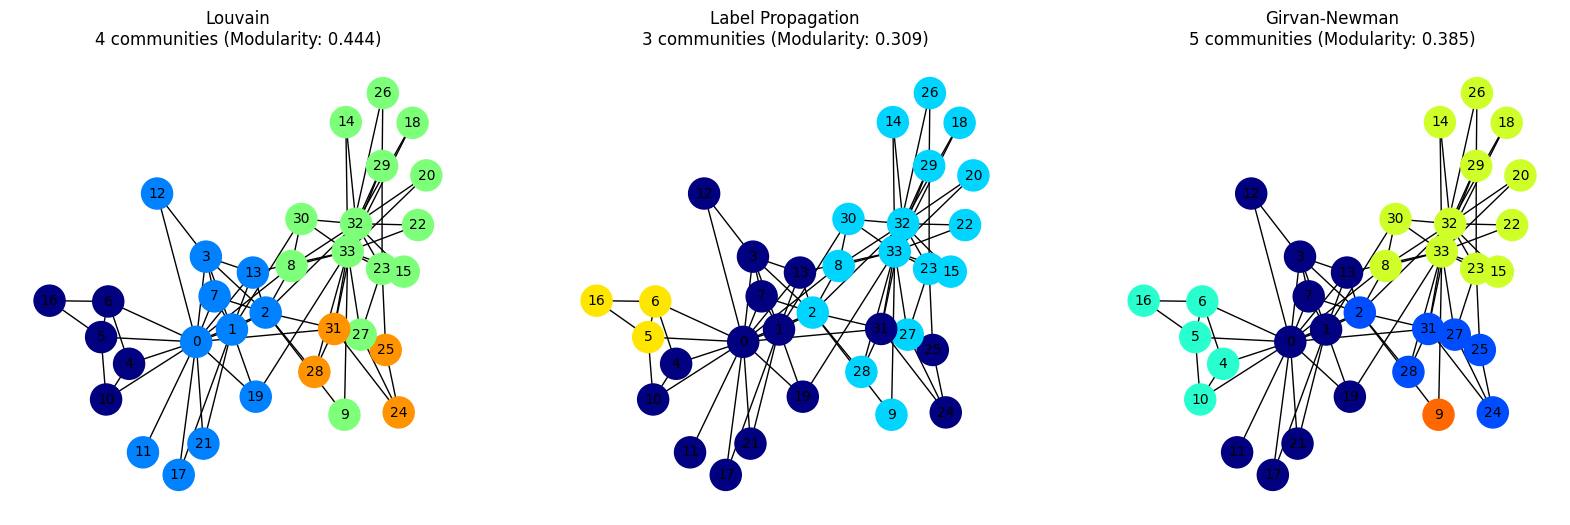

In [8]:
# Plot communities
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

visualize_communities(G, louvain_partition, "Louvain", axes[0])
visualize_communities(G, label_propagation_partition, "Label Propagation", axes[1])
visualize_communities(G, girvan_newman_partition, "Girvan-Newman", axes[2])

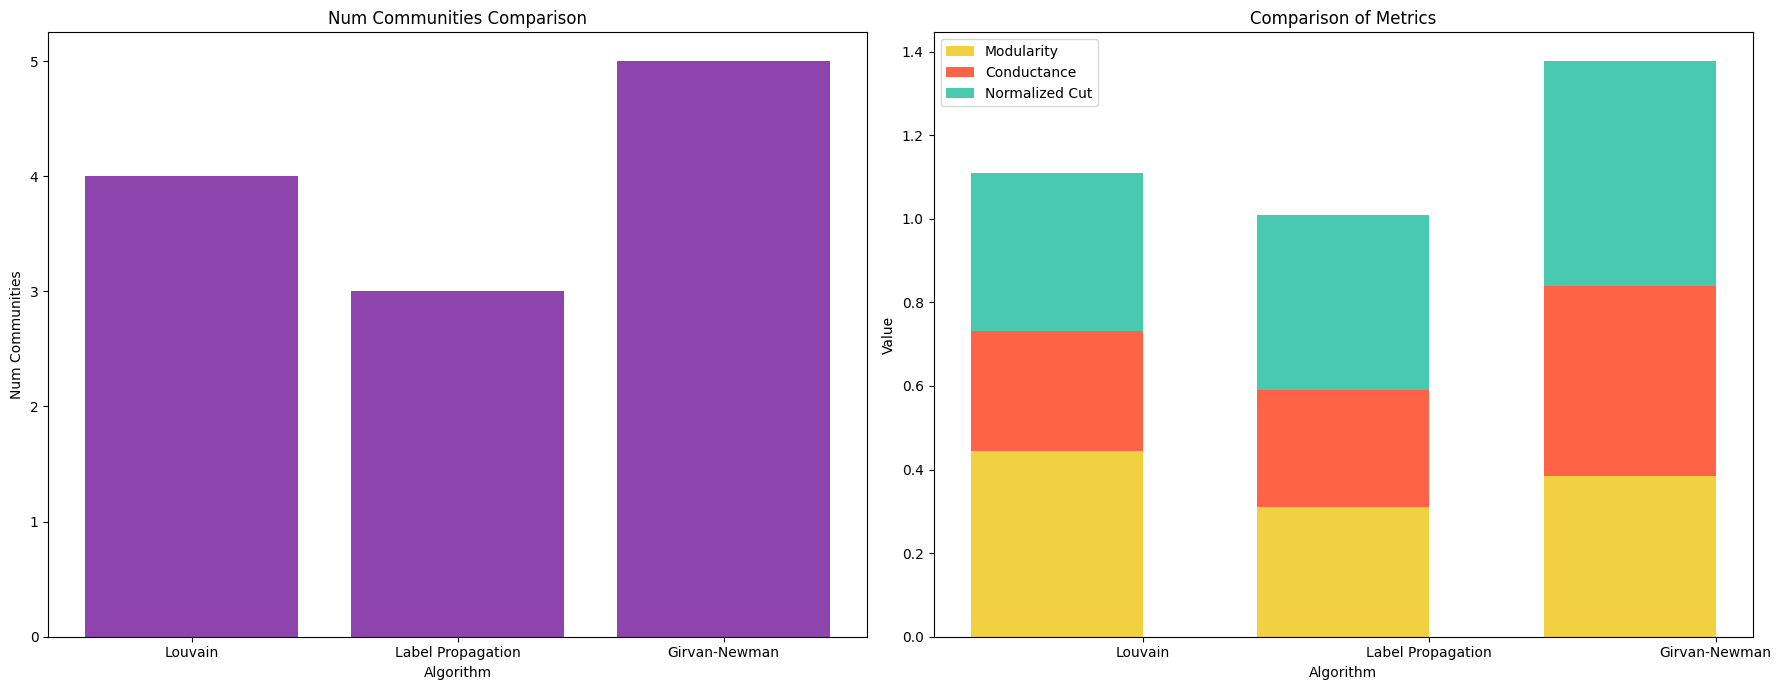

In [9]:
# Create DataFrame for metrics comparison
metrics_data = []
algorithms = ["Louvain", "Label Propagation", "Girvan-Newman"]

for partition, algorithm in zip(
    [louvain_partition, label_propagation_partition, girvan_newman_partition],
    algorithms,
):
    metrics = calculate_metrics(G, partition)
    metrics_data.append(
        {
            "Algorithm": algorithm,
            "Num Communities": metrics["num_communities"],
            "Modularity": metrics["modularity"],
            "Conductance": metrics["conductance"],
            "Normalized Cut": metrics["normalized_cut"],
        }
    )

metrics_df = pd.DataFrame(metrics_data)

# Plot the comparison of metrics
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Bar chart for comparing 'Num Communities' between algorithms
axes[0].bar(metrics_df["Algorithm"], metrics_df["Num Communities"], color="#8E44AD")
axes[0].set_title("Num Communities Comparison")
axes[0].set_xlabel("Algorithm")
axes[0].set_ylabel("Num Communities")

# Bar chart for comparing Modularity, Conductance, and Normalized Cut for each algorithm
bar_width = 0.6  # Increase the width of the bars
x = np.arange(len(metrics_df["Algorithm"]))  # X positions for each algorithm

axes[1].bar(
    x - bar_width / 2,
    metrics_df["Modularity"],
    width=bar_width,
    label="Modularity",
    color="#F2D140",
)
axes[1].bar(
    x - bar_width / 2,
    metrics_df["Conductance"],
    width=bar_width,
    label="Conductance",
    color="#FF6347",
    bottom=metrics_df["Modularity"],
)
axes[1].bar(
    x - bar_width / 2,
    metrics_df["Normalized Cut"],
    width=bar_width,
    label="Normalized Cut",
    color="#48C9B0",
    bottom=metrics_df["Modularity"] + metrics_df["Conductance"],
)

axes[1].set_title("Comparison of Metrics")
axes[1].set_xlabel("Algorithm")
axes[1].set_ylabel("Value")
axes[1].set_xticks(x)
axes[1].set_xticklabels(metrics_df["Algorithm"])
axes[1].legend()

plt.tight_layout()
plt.show()